In [1]:
import pandas as pd
import numpy as np
import holidays
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'data/load_scada_actual.csv')
print(df.columns)

Index(['load_name', 'timestamp', 'lmp', 'tag_actual', 'tag_scheduled',
       'netload', 'netload_source', 'gross_load', 'date_local', 'he_local',
       'tz', 'lastest_update_utc'],
      dtype='object')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215824 entries, 0 to 215823
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   load_name           215824 non-null  object 
 1   timestamp           215824 non-null  object 
 2   lmp                 22317 non-null   float64
 3   tag_actual          22355 non-null   float64
 4   tag_scheduled       2 non-null       float64
 5   netload             209132 non-null  float64
 6   netload_source      209132 non-null  object 
 7   gross_load          46078 non-null   float64
 8   date_local          215824 non-null  object 
 9   he_local            215824 non-null  int64  
 10  tz                  215824 non-null  object 
 11  lastest_update_utc  209132 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 19.8+ MB


In [5]:
df.drop(columns = ['lmp', 'tag_actual', 'tag_scheduled', 'netload_source', 'date_local', 'he_local', 'gross_load',
       'tz', 'lastest_update_utc'], inplace = True)
df

,load_name,timestamp,netload
0,KCEC,2024-07-30 19:00:00+00:00,12.0
1,KCEC,2024-07-30 20:00:00+00:00,22.0
2,KCEC,2024-07-30 21:00:00+00:00,24.0
3,KCEC,2024-07-31 01:00:00+00:00,33.0
4,KCEC,2024-07-31 02:00:00+00:00,24.0
...,...,...,...
215819,KCEC,2020-04-14 05:00:00+00:00,33.0
215820,KCEC,2019-11-21 06:00:00+00:00,33.0
215821,KCEC,2019-11-20 06:00:00+00:00,33.0
215822,KCEC,2019-11-06 06:00:00+00:00,33.0


In [6]:
df.load_name.value_counts()

load_name
HCE            46679
KCEC           44524
JICARILLA      44135
ACOMA          27393
RATON          25131
DMEA           21270
AZTEC           2698
UNITED PSCO     2009
UNITED WACM     1985
Name: count, dtype: int64

In [7]:
# non_null_values_count  = df[~df['actual_gross_load'].isna()].groupby('load_name').size()
# most_non_null_value_group = non_null_values_count.idxmax()
# print(most_non_null_value_group)
# df = df[df['load_name'] == most_non_null_value_group]

df = df[df['load_name'] == 'DMEA']
df.drop(columns = ['load_name'], inplace = True)
# actual gross load is empty for HCE

In [8]:
df

,timestamp,netload
47,2024-07-30 19:00:00+00:00,72.58
48,2024-07-30 20:00:00+00:00,77.77
49,2024-07-30 21:00:00+00:00,82.36
50,2024-07-30 22:00:00+00:00,84.14
51,2024-07-30 23:00:00+00:00,85.20
...,...,...
209662,2024-07-26 05:00:00+00:00,56.60
209663,2024-07-27 05:00:00+00:00,55.90
209664,2024-07-28 05:00:00+00:00,54.35
209665,2024-07-29 05:00:00+00:00,51.32


In [9]:
df = df.dropna() 
print(len(df))

21270


In [10]:
# sort by timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by = 'timestamp')
# split timestamp into month date and time
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['season'] = ['winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' for x in df['month']]
df['date'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dow'] = df['timestamp'].dt.dayofweek

In [11]:
print(df.columns)
df.info()

Index(['timestamp', 'netload', 'year', 'month', 'season', 'date', 'hour',
       'dow'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 21270 entries, 109752 to 63
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  21270 non-null  datetime64[ns, UTC]
 1   netload    21270 non-null  float64            
 2   year       21270 non-null  int32              
 3   month      21270 non-null  int32              
 4   season     21270 non-null  object             
 5   date       21270 non-null  int32              
 6   hour       21270 non-null  int32              
 7   dow        21270 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(5), object(1)
memory usage: 1.1+ MB


## Adding whether data

In [12]:
weather_df = pd.read_csv(r'data/DMEA_weather_data.csv')
weather_df

,index,temperature,solar_radiation,cloud_cover,humidity,wind_speed
0,2015-01-01 00:00:00+00:00,18.579321,0.0,30.915419,0.000000,2.423029
1,2015-01-01 01:00:00+00:00,15.854053,0.0,3.262689,0.000000,2.458667
2,2015-01-01 02:00:00+00:00,13.142407,0.0,1.875000,0.000000,2.116607
3,2015-01-01 03:00:00+00:00,12.213239,0.0,5.447345,0.000000,3.115575
4,2015-01-01 04:00:00+00:00,12.233124,0.0,41.087280,0.000000,1.917479
...,...,...,...,...,...,...
81798,2024-07-31 08:00:00+00:00,66.751624,0.0,0.000000,16.093412,4.421155
81799,2024-07-31 09:00:00+00:00,65.298682,0.0,0.000000,16.953800,3.711957
81800,2024-07-31 10:00:00+00:00,62.027557,0.0,0.000000,21.734526,3.720699
81801,2024-07-31 11:00:00+00:00,59.840289,0.0,0.000000,23.930729,3.353332


In [13]:
weather_df['timestamp'] = pd.to_datetime(weather_df['index'])
weather_df = weather_df.sort_values(by = 'timestamp')
# merge weather data with df
df = pd.merge(df, weather_df, on = 'timestamp', how = 'left')
#drop index column
df.drop(columns = ['index'], inplace = True)
df

,timestamp,netload,year,month,season,date,hour,dow,temperature,solar_radiation,cloud_cover,humidity,wind_speed
0,2021-10-21 18:00:00+00:00,45.17,2021,10,fall,21,18,3,53.693549,656.685242,67.000000,32.073475,1.991841
1,2021-10-21 19:00:00+00:00,48.08,2021,10,fall,21,19,3,57.486029,710.514648,11.611272,30.586985,1.543698
2,2021-10-21 20:00:00+00:00,47.85,2021,10,fall,21,20,3,60.400208,622.538208,59.856133,26.052521,1.782106
3,2021-10-21 21:00:00+00:00,49.14,2021,10,fall,21,21,3,62.212457,577.231445,2.051746,21.712488,2.218037
4,2021-10-21 22:00:00+00:00,51.61,2021,10,fall,21,22,3,62.565063,421.572235,0.000000,19.294811,2.095834
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21265,2024-07-31 07:00:00+00:00,48.46,2024,7,summer,31,7,2,68.434839,0.000000,0.000000,16.169823,4.481148
21266,2024-07-31 08:00:00+00:00,48.04,2024,7,summer,31,8,2,66.751624,0.000000,0.000000,16.093412,4.421155
21267,2024-07-31 09:00:00+00:00,44.21,2024,7,summer,31,9,2,65.298682,0.000000,0.000000,16.953800,3.711957
21268,2024-07-31 10:00:00+00:00,45.49,2024,7,summer,31,10,2,62.027557,0.000000,0.000000,21.734526,3.720699


# EDA

In [14]:
df.describe()

,netload,year,month,date,hour,dow,temperature,solar_radiation,cloud_cover,humidity,wind_speed
count,21270.000000,21270.000000,21270.000000,21270.000000,21270.000000,21270.000000,21080.000000,21080.000000,21080.000000,21080.000000,21080.000000
mean,62.424463,2022.856041,6.167936,15.814151,11.498213,2.999060,51.676603,215.102238,31.045525,44.155939,2.856401
std,14.039689,0.790393,3.387424,9.042157,6.930237,1.995811,24.976445,311.713491,40.947195,22.257775,1.704189
min,0.390000,2021.000000,1.000000,1.000000,0.000000,0.000000,-459.400000,0.000000,0.000000,0.000000,0.000000
25%,51.360000,2022.000000,3.000000,8.000000,5.000000,1.000000,35.254755,0.000000,0.000000,25.619880,1.739419
50%,61.860000,2023.000000,6.000000,16.000000,11.000000,3.000000,50.103024,0.000000,2.547412,42.610350,2.617153
75%,73.297500,2023.000000,9.000000,24.000000,18.000000,5.000000,66.894968,395.210297,73.662273,61.035764,3.491418
max,105.860000,2024.000000,12.000000,31.000000,23.000000,6.000000,1090.016852,1090.493042,200.000000,165.550156,14.999789


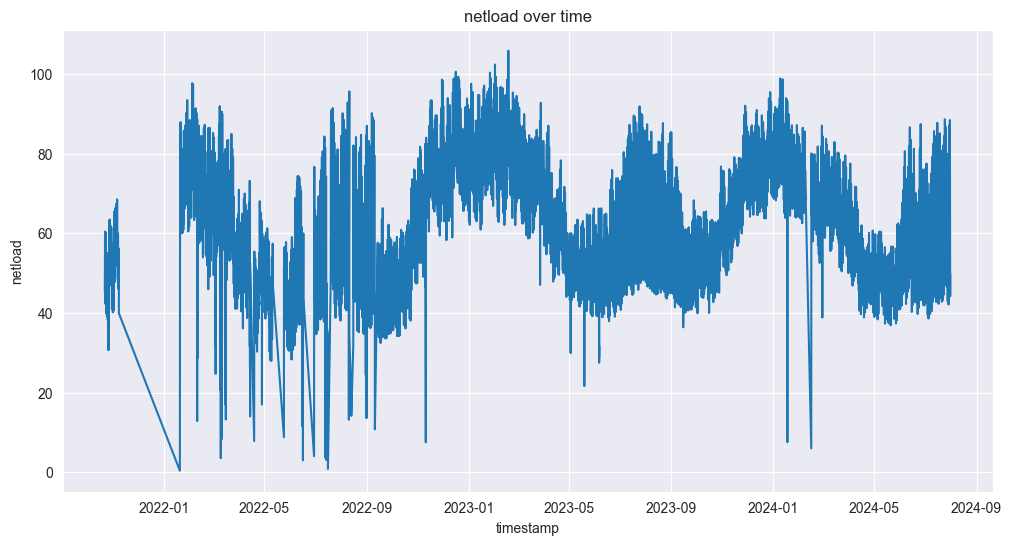

In [17]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being timestamp
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['netload'])
plt.title('netload over time')
plt.xlabel('timestamp')
plt.ylabel('netload')
plt.show()

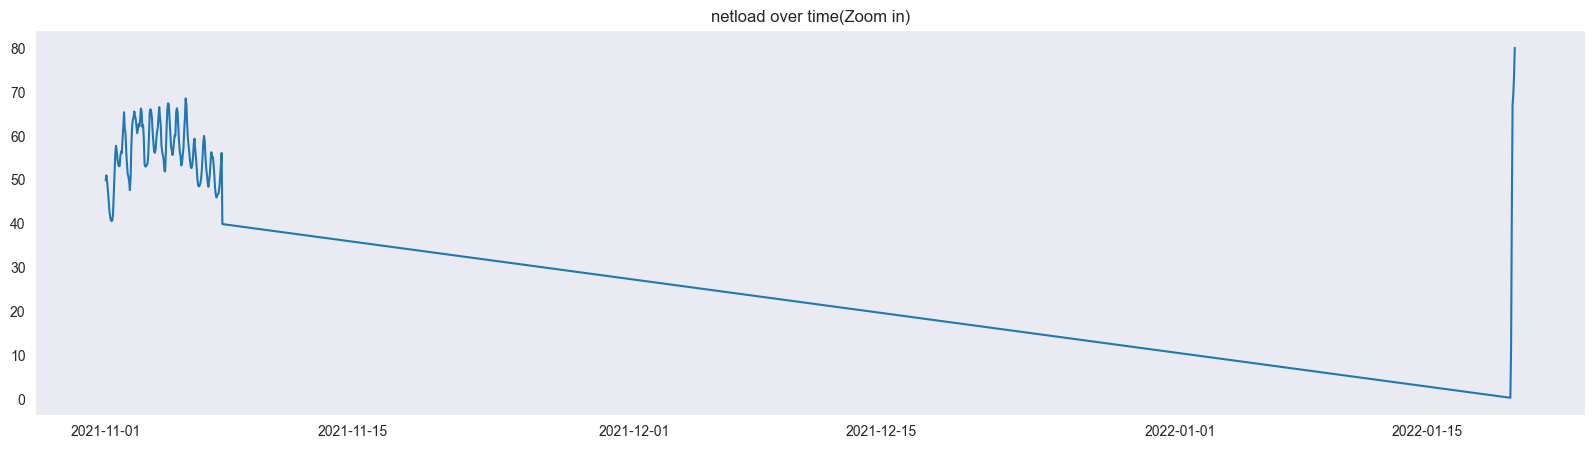

In [18]:
from datetime import datetime
from pytz import timezone
df_tmp = df.copy()
df_tmp['timestamp'] = pd.to_datetime(df_tmp['timestamp'])
df_tmp.set_index('timestamp', inplace=True)
df_tmp = df_tmp.loc[
    (df_tmp.index >= datetime(2021, 11, 1, tzinfo=timezone('UTC')))
    & (df_tmp.index <= datetime(2022, 1, 20, tzinfo=timezone('UTC')))
]

plt.figure(figsize=(20, 5))
plt.plot(df_tmp["netload"])
plt.title('netload over time(Zoom in)')
plt.grid()
plt.show()

In [19]:
# 2021-10-25 16:00:00+00:00
# Convert the 'timestamp' column to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter the DataFrame based on the timestamp range
start_date = '2021-11-07 00:00:00+00:00'
end_date = '2022-01-20 00:00:00+00:00'

filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
filtered_df

,timestamp,netload,year,month,season,date,hour,dow,temperature,solar_radiation,cloud_cover,humidity,wind_speed
390,2021-11-07 00:00:00+00:00,56.29,2021,11,fall,7,0,6,63.215289,0.000000,0.000000,15.280973,2.155310
391,2021-11-07 01:00:00+00:00,55.04,2021,11,fall,7,1,6,57.816663,0.000000,0.000000,20.305021,1.738493
392,2021-11-07 02:00:00+00:00,55.22,2021,11,fall,7,2,6,54.437982,0.000000,7.079650,25.347755,1.917852
393,2021-11-07 03:00:00+00:00,53.58,2021,11,fall,7,3,6,51.321106,0.000000,0.198315,28.338402,2.533162
394,2021-11-07 04:00:00+00:00,51.23,2021,11,fall,7,4,6,49.167181,0.000000,0.000000,24.261620,2.977973
395,2021-11-07 05:00:00+00:00,48.26,2021,11,fall,7,5,6,48.456586,0.000000,0.000000,24.776318,2.108555
396,2021-11-07 06:00:00+00:00,46.67,2021,11,fall,7,6,6,45.301257,0.000000,0.000000,30.192045,2.732633
397,2021-11-07 07:00:00+00:00,45.99,2021,11,fall,7,7,6,44.525677,0.000000,0.000000,31.444820,2.964890
398,2021-11-07 08:00:00+00:00,46.41,2021,11,fall,7,8,6,43.978394,0.000000,0.000000,28.804569,2.931232
399,2021-11-07 09:00:00+00:00,46.74,2021,11,fall,7,9,6,43.475824,0.000000,0.000000,28.725506,2.464126


In [20]:
# start from 2022-01-19 18:00:00+00:00
df = df[df['timestamp'] >= '2022-01-19 18:00:00+00:00']

In [21]:
# start and end date 
print(df['timestamp'].min())
print(df['timestamp'].max())

2022-01-19 18:00:00+00:00
2024-07-31 11:00:00+00:00


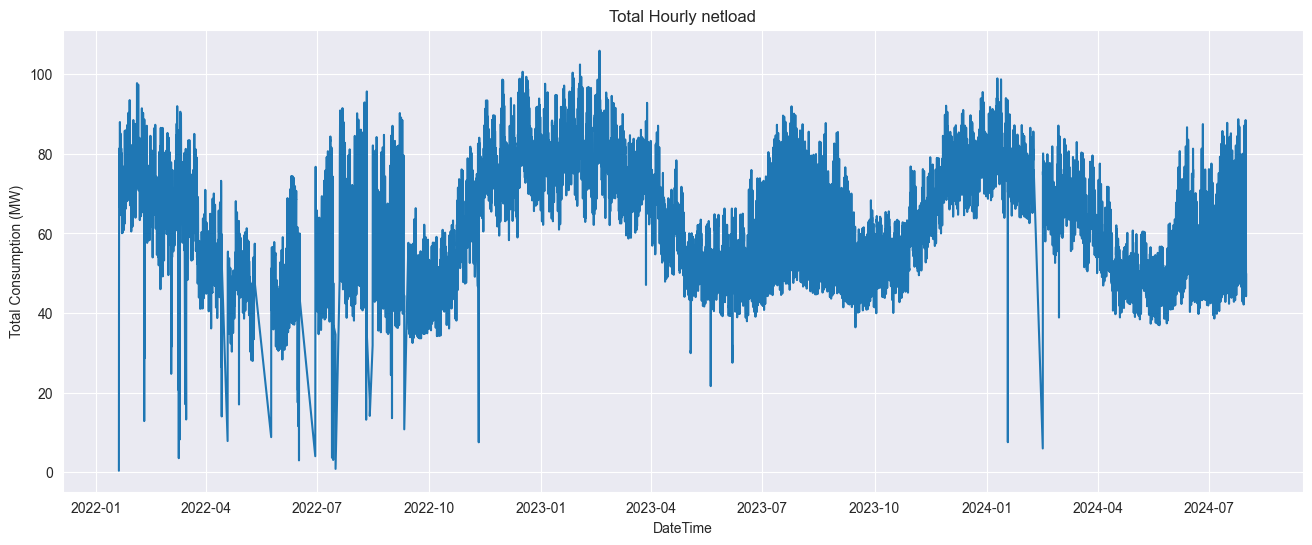

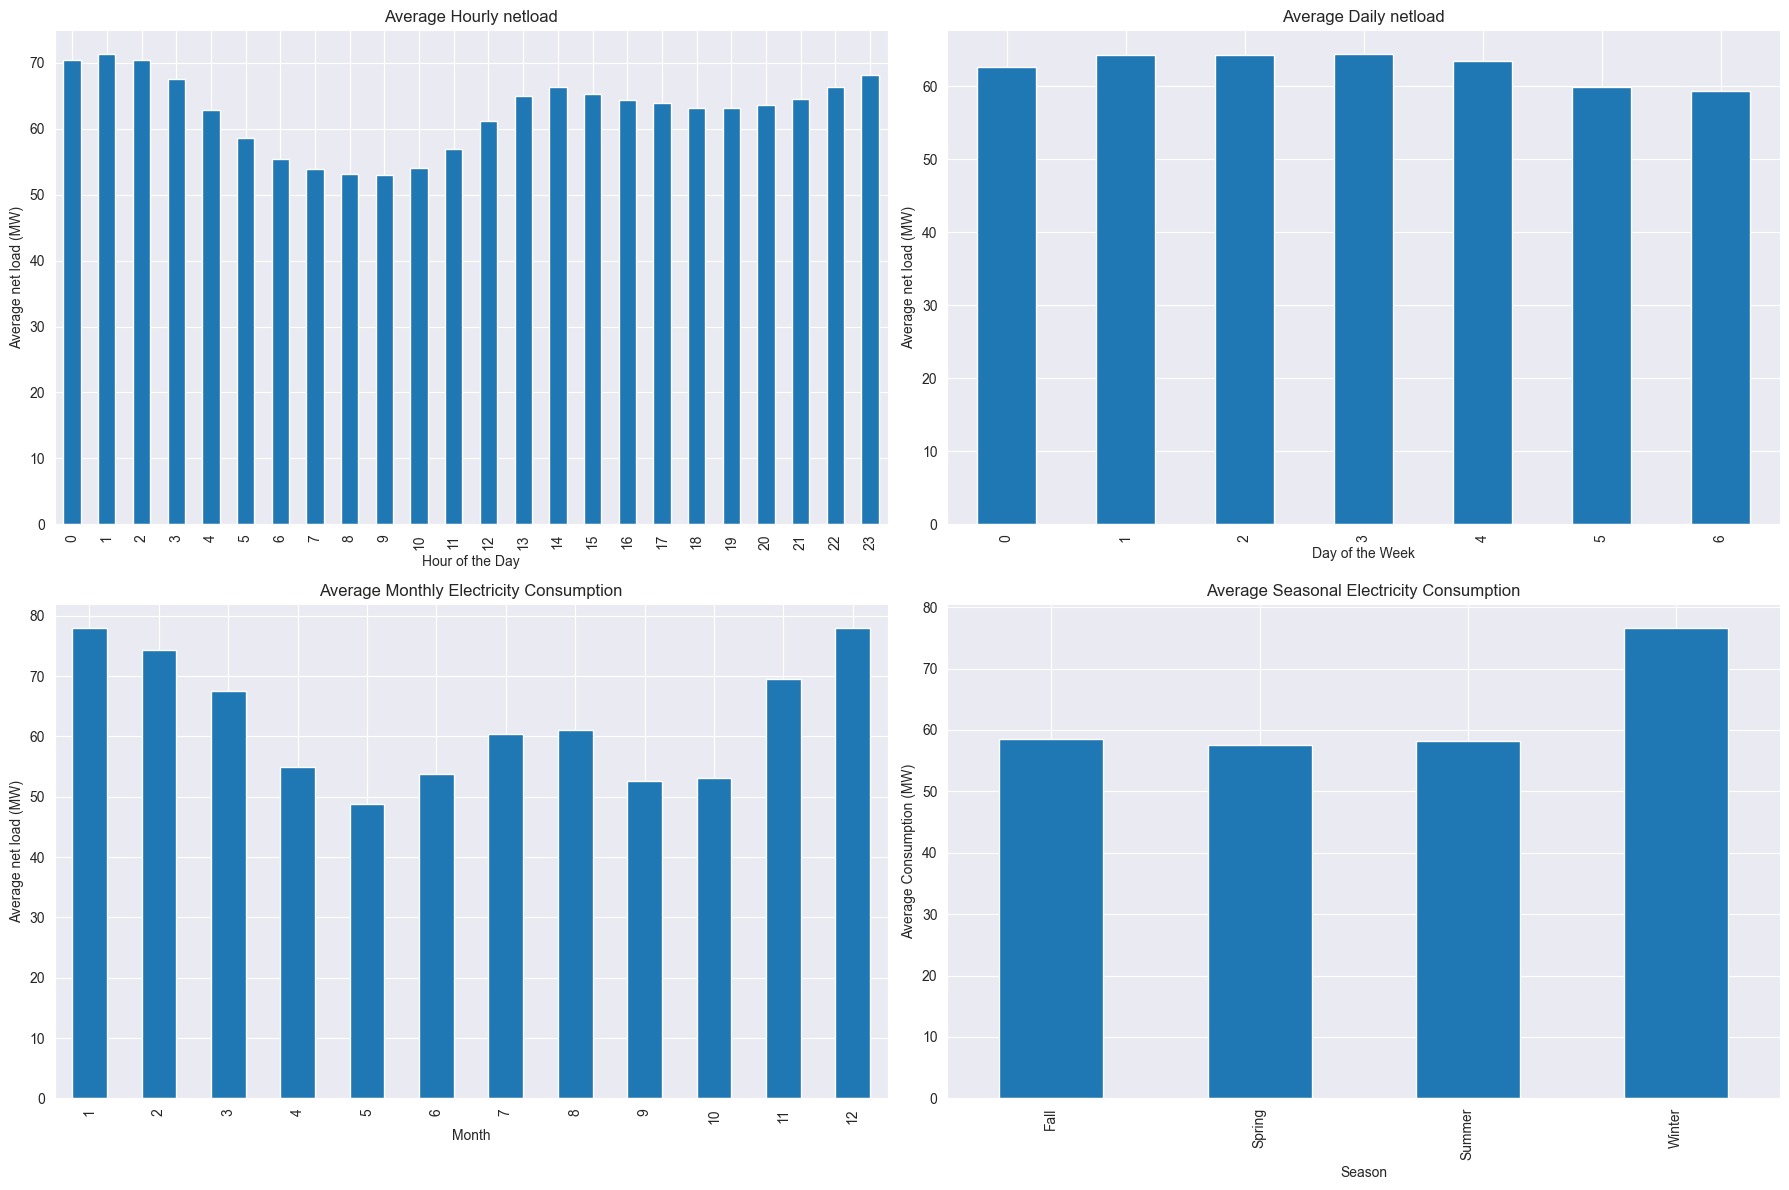

In [43]:
def plot_data(df):
    df = df.sort_values(by='timestamp')
    
    # Ensure necessary time features are added
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    
    # Define seasons
    df['season'] = df['timestamp'].dt.month % 12 // 3 + 1
    season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df['season'] = df['season'].map(season_mapping)
    
    # First plot: Time series plot
    plt.figure(figsize=(16, 6))
    plt.plot(df['timestamp'], df['netload'])
    plt.xlabel('DateTime')
    plt.ylabel('Total Consumption (MW)')
    plt.title('Total Hourly netload')
    plt.show()

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot by hour of the day
    hourly_consumption = df.groupby('hour')['netload'].mean()
    hourly_consumption.plot(kind='bar', ax=axs[0, 0])
    axs[0, 0].set_xlabel('Hour of the Day')
    axs[0, 0].set_ylabel('Average net load (MW)')
    axs[0, 0].set_title('Average Hourly netload')

    # Plot by day of the week
    daily_consumption = df.groupby('day_of_week')['netload'].mean()
    daily_consumption.plot(kind='bar', ax=axs[0, 1])
    axs[0, 1].set_xlabel('Day of the Week')
    axs[0, 1].set_ylabel('Average net load (MW)')
    axs[0, 1].set_title('Average Daily netload')

    # Plot by month
    monthly_consumption = df.groupby('month')['netload'].mean()
    monthly_consumption.plot(kind='bar', ax=axs[1, 0])
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('Average net load (MW)')
    axs[1, 0].set_title('Average Monthly Electricity Consumption')

    # Plot by season
    season_consumption = df.groupby('season')['netload'].mean()
    season_consumption.plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_xlabel('Season')
    axs[1, 1].set_ylabel('Average Consumption (MW)')
    axs[1, 1].set_title('Average Seasonal Electricity Consumption')
    
    plt.tight_layout()
    plt.show()

plot_data(df)

## Data preprocessing

In [23]:
# feature engineering
df['month_sin'] = np.sin((df['month'] - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month'] - 1) * (2. * np.pi / 12))
df['day_sin'] = np.sin((df['date'] - 1) * (2. * np.pi / 31))
df['day_cos'] = np.cos((df['date'] - 1) * (2. * np.pi / 31))
df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))
df['dow_sin'] = np.sin(df['dow'] * (2. * np.pi / 7))
df['dow_cos'] = np.cos(df['dow'] * (2. * np.pi / 7))

# holiday feature
us_holidays = holidays.US()
df['is_holiday'] = df['timestamp'].apply(lambda x: x in us_holidays)
df['is_holiday'] = df['is_holiday'].astype(int)

Number of outliers: 417


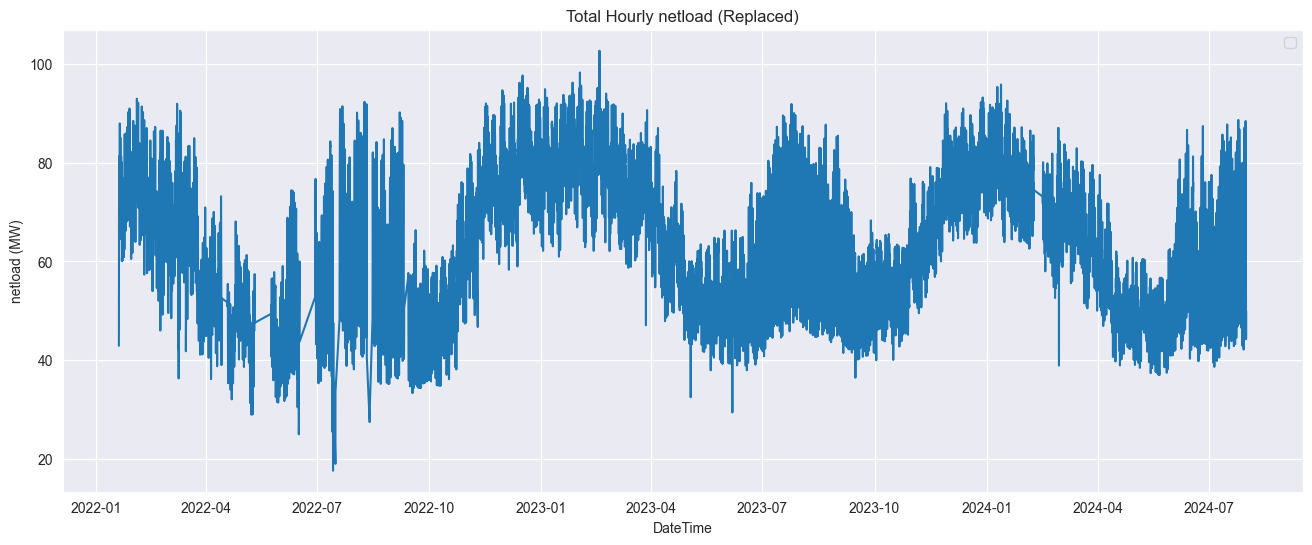

In [44]:
# define the outliers as the values outside of the 0.5% and 99.5% quantiles
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'timestamp' and 'netload' are the relevant columns
df['netload_replaced'] = replace_outliers_with_avg(df['netload'].copy())

# Number of outliers
print(f'Number of outliers: {df[df["netload"] != df["netload_replaced"]].shape[0]}')

# Plot the replaced 'netload_replaced'
plt.figure(figsize=(16, 6))
plt.plot(df['timestamp'], df['netload_replaced'])
plt.xlabel('DateTime')
plt.ylabel('netload (MW)')
plt.title('Total Hourly netload (Replaced)')
plt.legend()
plt.show()

In [25]:
# 3 days shift
df_ = df.copy()

# Calculate the timestamp 3 days ago
df_['timestamp_3d'] = df_['timestamp'] - pd.Timedelta(days=3)
df_['timestamp_3d'] = df_['timestamp_3d'].dt.floor('H')

# Rename columns to avoid duplication
df_3d = df_[['timestamp', 'netload_replaced']].copy()
df_3d.columns = ['timestamp_3d', 'netload_replaced_3d']

# Merge the 3 days ago data with the original data
df_merged = df_.merge(df_3d, left_on='timestamp_3d', right_on='timestamp_3d', how='left')

# Display information about the merged DataFrame
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20864 entries, 0 to 20863
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   timestamp            20864 non-null  datetime64[ns, UTC]
 1   netload              20864 non-null  float64            
 2   year                 20864 non-null  int32              
 3   month                20864 non-null  int32              
 4   season               20864 non-null  object             
 5   date                 20864 non-null  int32              
 6   hour                 20864 non-null  int32              
 7   dow                  20864 non-null  int32              
 8   temperature          20674 non-null  float64            
 9   solar_radiation      20674 non-null  float64            
 10  cloud_cover          20674 non-null  float64            
 11  humidity             20674 non-null  float64            
 12  wind_speed        

In [26]:
# print out where netload_3d is null
df_merged[df_merged['netload_replaced_3d'].isnull()]

,timestamp,netload,year,month,season,date,hour,dow,temperature,solar_radiation,...,day_sin,day_cos,hour_sin,hour_cos,dow_sin,dow_cos,is_holiday,netload_replaced,timestamp_3d,netload_replaced_3d
0,2022-01-19 18:00:00+00:00,0.39,2022,1,winter,19,18,2,36.182660,370.082306,...,-0.485302,-0.874347,-1.000000,-1.836970e-16,0.974928,-0.222521,0,NaN,2022-01-16 18:00:00+00:00,NaN
1,2022-01-19 19:00:00+00:00,11.84,2022,1,winter,19,19,2,38.687543,257.615509,...,-0.485302,-0.874347,-0.965926,2.588190e-01,0.974928,-0.222521,0,NaN,2022-01-16 19:00:00+00:00,NaN
2,2022-01-19 20:00:00+00:00,42.88,2022,1,winter,19,20,2,40.741547,547.308533,...,-0.485302,-0.874347,-0.866025,5.000000e-01,0.974928,-0.222521,0,42.88,2022-01-16 20:00:00+00:00,NaN
3,2022-01-19 21:00:00+00:00,66.92,2022,1,winter,19,21,2,41.942792,502.412262,...,-0.485302,-0.874347,-0.707107,7.071068e-01,0.974928,-0.222521,0,66.92,2022-01-16 21:00:00+00:00,NaN
4,2022-01-19 22:00:00+00:00,69.56,2022,1,winter,19,22,2,42.406305,373.952393,...,-0.485302,-0.874347,-0.500000,8.660254e-01,0.974928,-0.222521,0,69.56,2022-01-16 22:00:00+00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16930,2024-02-18 14:00:00+00:00,75.44,2024,2,winter,18,14,6,23.177045,0.000000,...,-0.299363,-0.954139,-0.500000,-8.660254e-01,-0.781831,0.623490,0,75.44,2024-02-15 14:00:00+00:00,NaN
16931,2024-02-18 15:00:00+00:00,77.68,2024,2,winter,18,15,6,25.878967,18.841860,...,-0.299363,-0.954139,-0.707107,-7.071068e-01,-0.781831,0.623490,0,77.68,2024-02-15 15:00:00+00:00,NaN
16932,2024-02-18 16:00:00+00:00,77.24,2024,2,winter,18,16,6,31.713586,93.224030,...,-0.299363,-0.954139,-0.866025,-5.000000e-01,-0.781831,0.623490,0,77.24,2024-02-15 16:00:00+00:00,NaN
16933,2024-02-18 17:00:00+00:00,74.75,2024,2,winter,18,17,6,35.545178,22.514320,...,-0.299363,-0.954139,-0.965926,-2.588190e-01,-0.781831,0.623490,0,74.75,2024-02-15 17:00:00+00:00,NaN


In [27]:
# df_merged drop nan
df_merged.dropna(inplace=True)
df_merged.columns

Index(['timestamp', 'netload', 'year', 'month', 'season', 'date', 'hour',
       'dow', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity',
       'wind_speed', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_holiday',
       'netload_replaced', 'timestamp_3d', 'netload_replaced_3d'],
      dtype='object')

In [28]:
# Normalize the data and convert to time series data
from sklearn.preprocessing import MinMaxScaler

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged = df_merged.sort_values(by = 'timestamp')
# features and target
df_model = df_merged[['netload_replaced', 'netload_replaced_3d', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity',
       'wind_speed']]


features = ['netload_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity','wind_speed']
features_to_scale = ['netload_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature', 'solar_radiation', 'cloud_cover', 'humidity','wind_speed']
target_column = ['netload_replaced']
#non_scaled_features = ['is_holiday']

columns_to_scale = features_to_scale + target_column

# Scale the feature columns and target column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df_model[columns_to_scale])
LSTM_df = pd.DataFrame(scaled_df, columns=columns_to_scale, index=df_model.index)
LSTM_df

,netload_replaced_3d,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dow_sin,dow_cos,temperature,solar_radiation,cloud_cover,humidity,wind_speed,netload_replaced
74,0.205565,0.5,1.0,0.050521,0.277951,0.066987,0.750000,0.000000,0.356896,0.320563,0.257023,0.500268,0.441337,0.039796,0.511635
75,0.524880,0.5,1.0,0.050521,0.277951,0.146447,0.853553,0.000000,0.356896,0.321561,0.463028,0.126753,0.409061,0.008701,0.500477
76,0.559946,0.5,1.0,0.050521,0.277951,0.250000,0.933013,0.000000,0.356896,0.322607,0.350211,0.019385,0.388261,0.033653,0.507054
77,0.611616,0.5,1.0,0.050521,0.277951,0.370590,0.982963,0.000000,0.356896,0.322655,0.193267,0.003273,0.350356,0.129865,0.542877
78,0.699414,0.5,1.0,0.015339,0.373065,0.500000,1.000000,0.099031,0.801938,0.321121,0.026591,0.000000,0.352669,0.114282,0.631788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20859,0.265869,0.5,0.0,0.399221,0.989739,0.982963,0.370590,1.000000,0.356896,0.340667,0.000000,0.000000,0.097673,0.298747,0.363058
20860,0.236912,0.5,0.0,0.399221,0.989739,0.933013,0.250000,1.000000,0.356896,0.339580,0.000000,0.000000,0.097212,0.294748,0.358125
20861,0.214465,0.5,0.0,0.399221,0.989739,0.853553,0.146447,1.000000,0.356896,0.338643,0.000000,0.000000,0.102409,0.247467,0.313141
20862,0.205698,0.5,0.0,0.399221,0.989739,0.750000,0.066987,1.000000,0.356896,0.336531,0.000000,0.000000,0.131287,0.248050,0.328175


In [29]:
# Split the data into k-fold and out of sample
LSTM_df_ofs = LSTM_df.iloc[-2000:, :]
LSTM_df = LSTM_df.iloc[:-2000, :]

In [ ]:
def lstm_data(df,timestamps):
    array_data=df.values
    sc=MinMaxScaler()
    array_data_=sc.fit_transform(array_data)

    array=np.empty((0,array_data_.shape[1]))
    range_=array_data_.shape[0]-(timestamps-1)
    for t in range(range_):
        array_data_p=array_data_[t:t+timestamps,:]
        array=np.vstack((array,array_data_p))

    array_=array.reshape(-1,timestamps, array.shape[1])
    return array_

#timestamps depend on your objection, but not '1'
x_data=lstm_data(x, timestamps=4) 
y_data=lstm_data(y, timestamps=4)
y_data=y_data.reshape(-1,1)

#Divide each data into train and test
#Input the divided data into your LSTM m

In [30]:
# split into train and test sets
values = LSTM_df.values
n_train_hours = 365 * 36
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]  # x: All columns except the last,  y: The last column
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [number of samples, timesteps, Number of features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 14) (13140,) (4897, 1, 14) (4897,)


In [31]:
LSTM_df.columns

Index(['netload_replaced_3d', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'temperature',
       'solar_radiation', 'cloud_cover', 'humidity', 'wind_speed',
       'netload_replaced'],
      dtype='object')

Epoch 1/50
548/548 - 2s - 4ms/step - loss: 0.1099 - mae: 0.1099 - mape: 18629.8281 - mse: 0.0245 - val_loss: 0.1248 - val_mae: 0.1248 - val_mape: 20.8596 - val_mse: 0.0228 - learning_rate: 0.0010
Epoch 2/50
548/548 - 0s - 870us/step - loss: 0.0790 - mae: 0.0790 - mape: 27541.5898 - mse: 0.0103 - val_loss: 0.1261 - val_mae: 0.1261 - val_mape: 20.7336 - val_mse: 0.0231 - learning_rate: 0.0010
Epoch 3/50
548/548 - 1s - 1ms/step - loss: 0.0741 - mae: 0.0741 - mape: 26455.2773 - mse: 0.0092 - val_loss: 0.1227 - val_mae: 0.1227 - val_mape: 20.2266 - val_mse: 0.0218 - learning_rate: 0.0010
Epoch 4/50
548/548 - 0s - 860us/step - loss: 0.0706 - mae: 0.0706 - mape: 26774.4141 - mse: 0.0083 - val_loss: 0.1325 - val_mae: 0.1325 - val_mape: 22.0145 - val_mse: 0.0246 - learning_rate: 0.0010
Epoch 5/50
548/548 - 0s - 863us/step - loss: 0.0680 - mae: 0.0680 - mape: 23287.9395 - mse: 0.0078 - val_loss: 0.1196 - val_mae: 0.1196 - val_mape: 19.8839 - val_mse: 0.0205 - learning_rate: 0.0010
Epoch 6/50
548

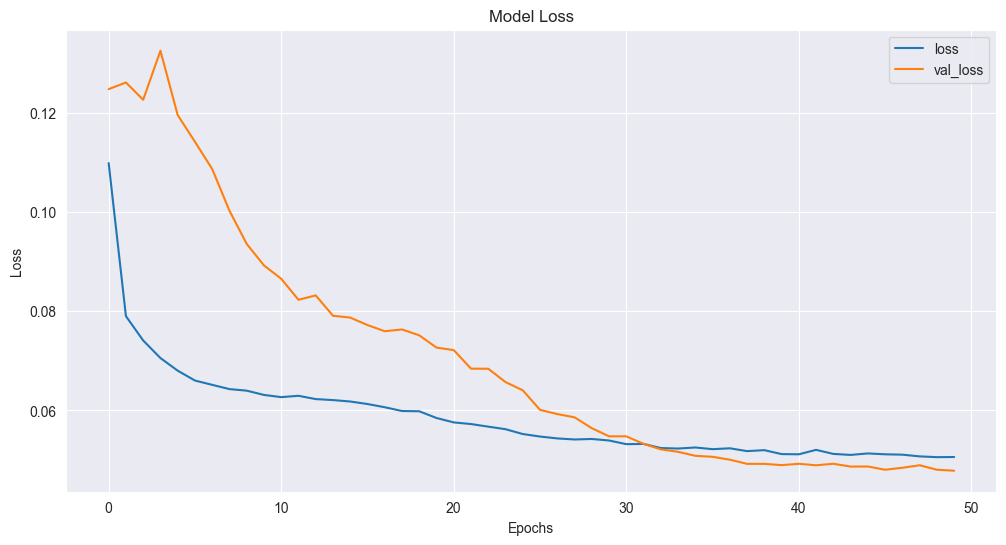

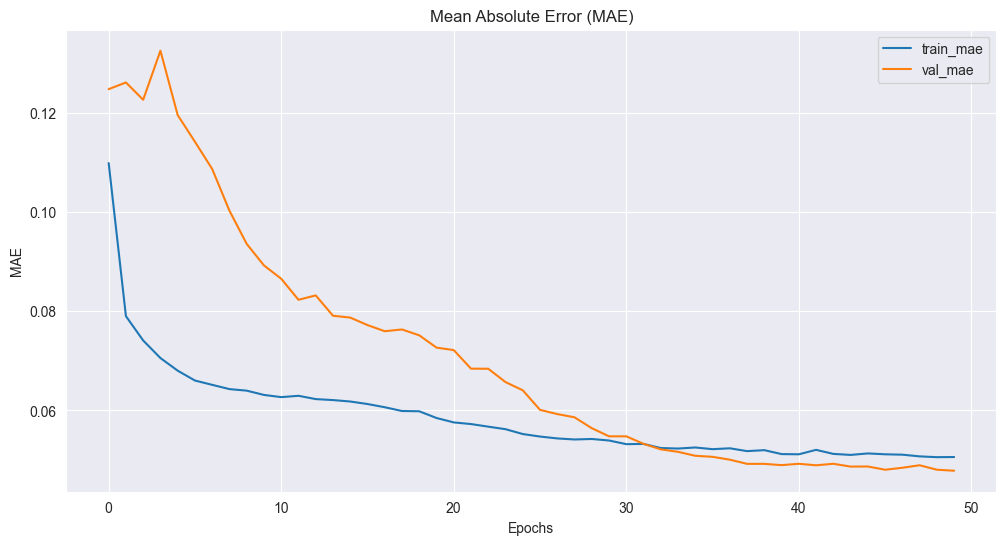

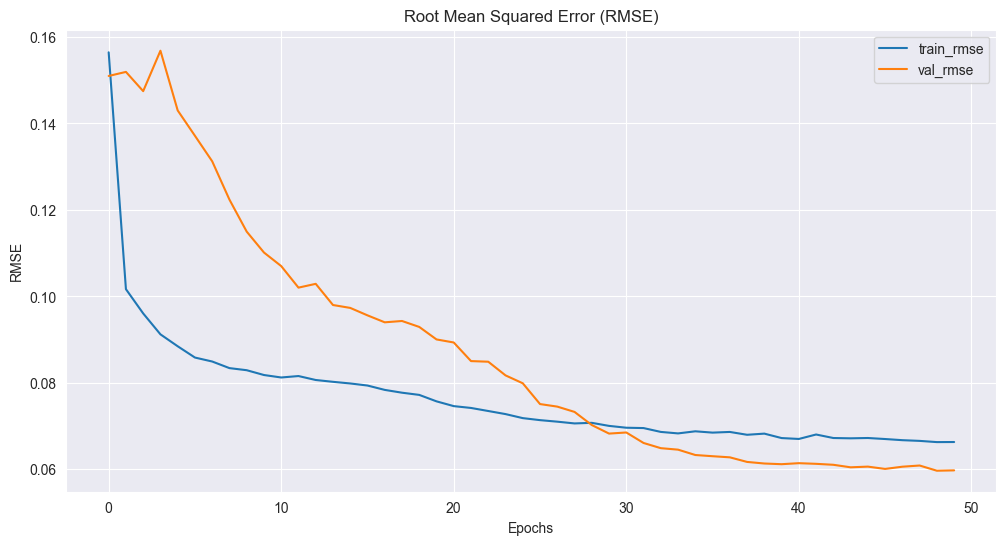

In [32]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# Fit the network
history = model.fit(train_X, train_y, epochs=50, batch_size=24, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

# Calculate MAPE manually
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

train_mape = safe_mape(train_y, train_predictions.squeeze())
test_mape = safe_mape(test_y, test_predictions.squeeze())


print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')

# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [33]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error

yhat = model.predict(test_X)
# print(yhat.shape) # (7442, 1)
# print(yhat)
# 2D [number of samples, number of features]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# print(test_X.shape) # (7442, 9)
# [number of samples, timesteps, Number of features]

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X), axis=1)  
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0] # first column

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0] # first column

# show the training performance metrics

# calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
MAPE = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % MAPE)

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
Test RMSE: 4.497
Test MAE: 3.601
Test MAPE: 5.228


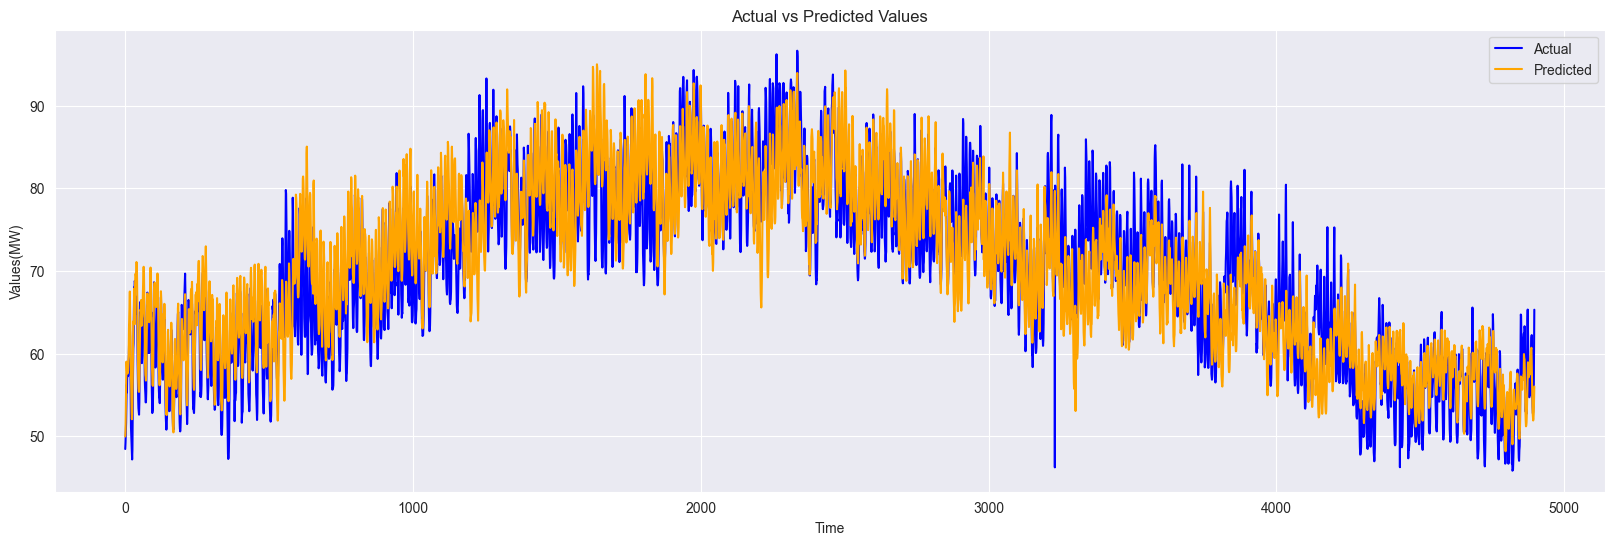

In [34]:
# merge the timestamp 


plt.figure(figsize=(20, 6))
plt.plot(inv_y, label='Actual', color='blue')
plt.plot(inv_yhat, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values(MW)')
plt.legend()
plt.grid(True)
plt.show()

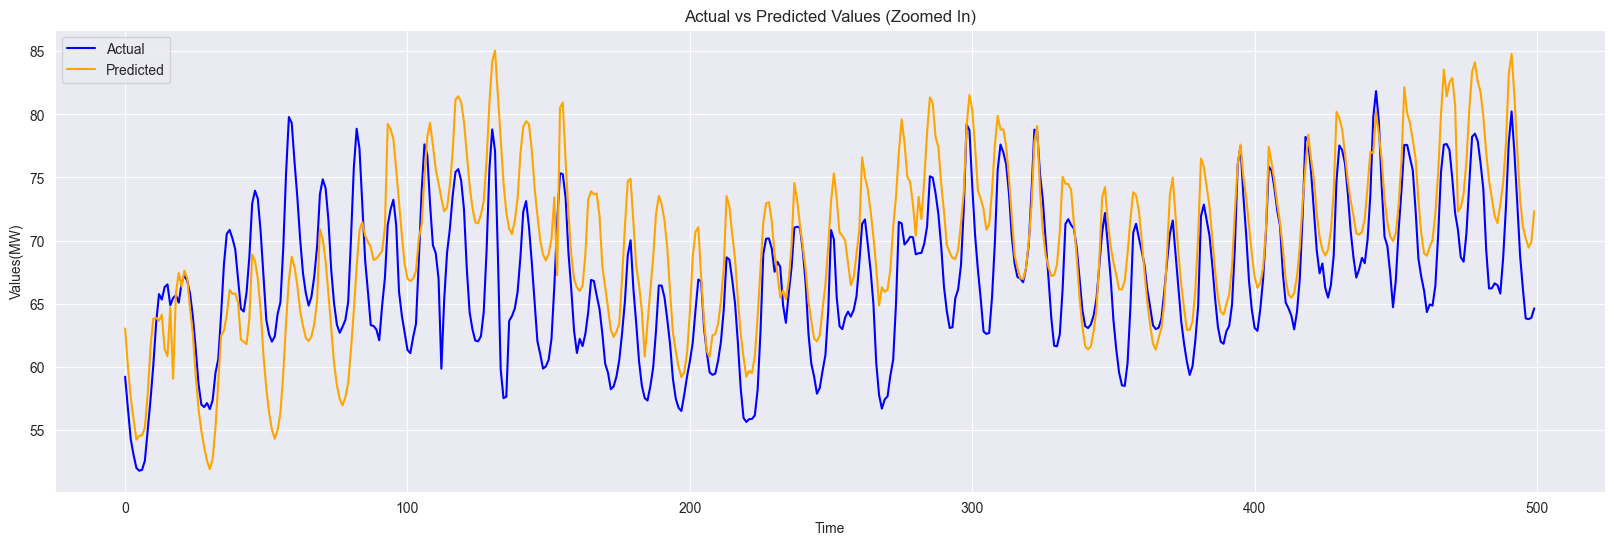

In [42]:
# Zoom in to plot
plt.figure(figsize=(20, 6))
plt.plot(inv_y[500:1000], label='Actual', color='blue')
plt.plot(inv_yhat[500:1000], label='Predicted', color='orange')
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Values(MW)')
plt.legend()
plt.grid(True)
plt.show()


# use the ofs data to predict

In [36]:
# LSTM_df_ofs = LSTM_df.iloc[-2000:, :]
# reshape
ofs_values = LSTM_df_ofs.values
# Split into input and output
ofs_X, ofs_y = ofs_values[:, :-1], ofs_values[:, -1]
# Reshape input to be 3D [number of samples, timesteps, number of features]
ofs_X = ofs_X.reshape((ofs_X.shape[0], 1, ofs_X.shape[1]))
print(ofs_X.shape, ofs_y.shape)

(2000, 1, 14) (2000,)


In [37]:
# Make predictions
ofs_predictions = model.predict(ofs_X)

# Reshape OFS data to original 2D shape for inverse transformation
ofs_X_reshaped = ofs_X.reshape((ofs_X.shape[0], ofs_X.shape[2]))

# Invert scaling for forecast
inv_ofs_predictions = concatenate((ofs_predictions, ofs_X_reshaped), axis=1)
inv_ofs_predictions = scaler.inverse_transform(inv_ofs_predictions)
inv_ofs_predictions = inv_ofs_predictions[:, 0]  # First column

# Invert scaling for actual
ofs_y = ofs_y.reshape((len(ofs_y), 1))
inv_ofs_y = concatenate((ofs_y, ofs_X_reshaped), axis=1)
inv_ofs_y = scaler.inverse_transform(inv_ofs_y)
inv_ofs_y = inv_ofs_y[:, 0]  # First column

# Calculate RMSE, MAE, MAPE
ofs_rmse = sqrt(mean_squared_error(inv_ofs_y, inv_ofs_predictions))
ofs_mae = mean_absolute_error(inv_ofs_y, inv_ofs_predictions)
ofs_mape = np.mean(np.abs((inv_ofs_y - inv_ofs_predictions) / inv_ofs_y)) * 100

print('OFS RMSE: %.3f' % ofs_rmse)
print('OFS MAE: %.3f' % ofs_mae)
print('OFS MAPE: %.3f' % ofs_mape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
OFS RMSE: 4.269
OFS MAE: 3.164
OFS MAPE: 5.192


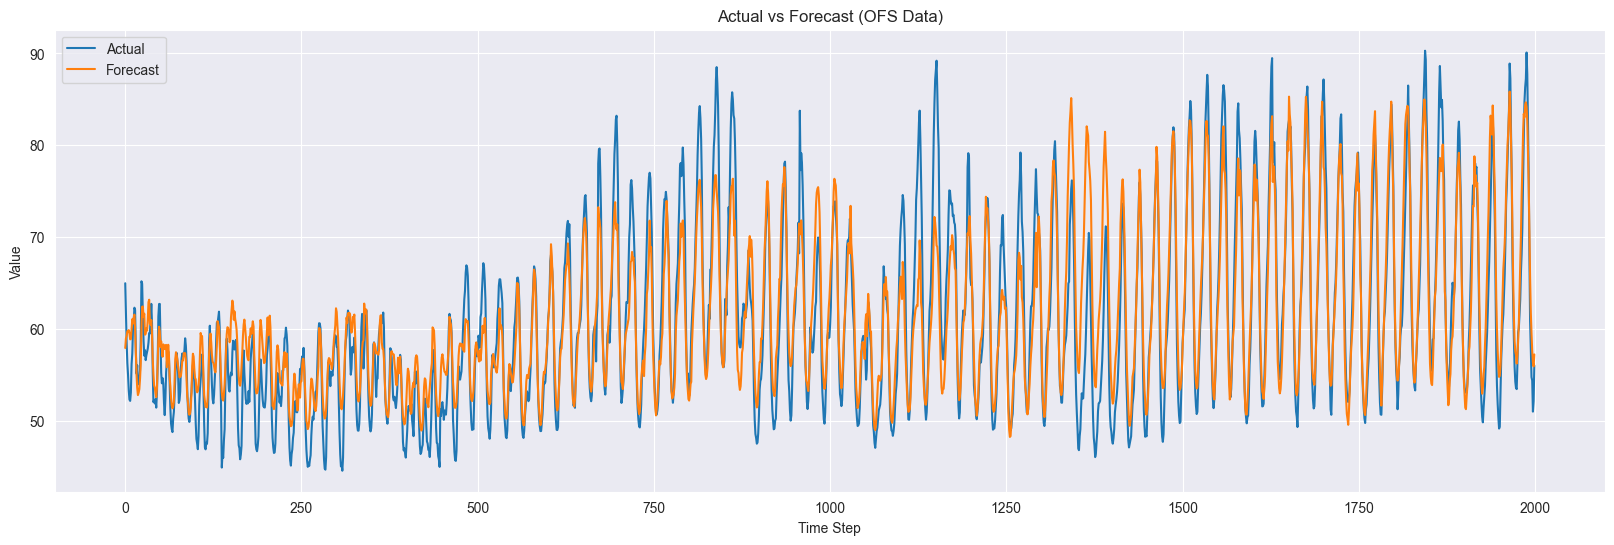

In [38]:
# Plot prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(inv_ofs_y, label='Actual')
plt.plot(inv_ofs_predictions, label='Forecast')
plt.title('Actual vs Forecast (OFS Data)')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [38]:
# make forecast based on the model
